In [1]:
import pandas as pd
import numpy as np
import COPP_Utils

%matplotlib inline

In [2]:
# load different datasets for future append
sen = pd.read_csv('sensor_data.csv', parse_dates=True, index_col='datetime')
occ = pd.read_csv('occupancy_data.csv', parse_dates=True, index_col='datetime')
imgs = pd.read_csv('image_variations.csv', parse_dates=True, index_col='datetime')
door = pd.read_csv('door_data.csv', parse_dates=True, index_col='datetime', dtype={'door_status':'category'})

#sensorand image  data from nik's office (night data)
sen_ofc = pd.read_csv('sensor_data-nik.csv', parse_dates=True, index_col='datetime')
imgs_ofc = pd.read_csv('image_variations-nik.csv', parse_dates=True, index_col='datetime')


# deleting irrelevant columns
# be sure to remove columns that will be duplicated when concatenating (such as location)
del sen['location']
del sen['loc_CO2']
del sen_ofc['location']
del sen_ofc['loc_CO2']
# it was demonstrated that 'bluetooth_devices' and 'bluetooth_non_personal_devices'
# are highly correlated so we can delete the latter one.
del sen['bluetooth_non_personal_devices']
del sen_ofc['bluetooth_non_personal_devices']
#renaming occupancy count to a proper name
occ.count_total.name = 'occupancy_count'
occ = occ['count_total']
#renaming image histogram change to a proper name
imgs.rolling_rms.name = 'image_hist_change'
imgs = imgs['rolling_rms']
imgs_ofc.rolling_rms.name = 'image_hist_change'
imgs_ofc = imgs_ofc['rolling_rms']
# drop door DateTimeIndex duplicates, keeping last seen: As two
# events may occur in the same second (door quickly opening and
# closing), this database may contain "duplicated" datetimes.
door['datetime'] = door.index
door.drop_duplicates(subset='datetime', keep='last', inplace=True)
door = door['door_status']

In [3]:
# Clean up outliers from sensor data:

# Delete -999 values from temperature
print("before temp outliers removal:", len(sen), len(sen_ofc))
sen = sen[sen.temperature != -999]
sen_ofc = sen_ofc[sen_ofc.temperature != -999]
print("after temp outliers removal:", len(sen), len(sen_ofc))

# Delete 2 values from co2
print("----\nbefore co2 outliers removal:", len(sen), len(sen_ofc))
sen = sen[sen.co2 != 2]
sen_ofc = sen_ofc[sen_ofc.co2 != 2]
print("after co2 outliers removal:", len(sen), len(sen_ofc))

before temp outliers removal: 46275 45979
after temp outliers removal: 46273 45979
----
before co2 outliers removal: 46273 45979
after co2 outliers removal: 46242 45979


In [4]:
# bluetooth data for office set has a complexity,
# as the sebsors were run continuously for several days, the captured
# values are only incrementing. To solve this issue and make the feature
# equivalent to the classroom data, every day the count will be reset.

days = sen_ofc.to_period('D').index.unique()
dates = [d.strftime("%Y-%m-%d") for d in days]

for d in dates:
    starting_val = sen_ofc[d].bluetooth_devices[0]
    sen_ofc.loc[d,'bluetooth_devices'] = sen_ofc[d].bluetooth_devices - starting_val + 1

In [5]:
# interpolate sensor missing-data gaps (using 'pchip' method)
sen = COPP_Utils.interpolateByDay(sen)
sen_ofc = COPP_Utils.interpolateByDay(sen_ofc)

In [6]:
# Adding extra features to sensors:

# temperature in Farenheit degrees
sen['temperature_f'] = 9.0/5.0 * sen.temperature + 32
sen_ofc['temperature_f'] = 9.0/5.0 * sen_ofc.temperature + 32

# light switch on and off, selected threshold: <700 is on, otherwise is off
sen['light_status'] = (sen.loc[:,'light'] < 700).astype(int)
sen_ofc['light_status'] = (sen_ofc.loc[:,'light'] < 700).astype(int)

#reorganizing columns
sen = sen[['temperature', 
           'temperature_f', 
           'humidity', 'co2', 'light', 
           'light_status',
           'noise', 'bluetooth_devices']]
sen_ofc = sen_ofc[['temperature', 
           'temperature_f', 
           'humidity', 'co2', 'light', 
           'light_status',
           'noise', 'bluetooth_devices']]

In [7]:
# first append image comparison feature ('rolling_rms')
extended_set = COPP_Utils.appendFeature(sen, imgs, 'temperature')
extended_set_ofc = COPP_Utils.appendFeature(sen_ofc, imgs_ofc, 'temperature')

# cases where the initial rolling_rms is zero, can be set to NaN and then bfilled
extended_set.image_hist_change[extended_set.image_hist_change == 0] = np.nan
extended_set.image_hist_change = extended_set.image_hist_change.bfill()
# same for office data
extended_set_ofc.loc[extended_set_ofc.image_hist_change == 0,['image_hist_change']] = np.nan
extended_set_ofc.image_hist_change = extended_set_ofc.image_hist_change.bfill()

print(extended_set.head(3))
print(extended_set_ofc.head(3))

                     temperature  temperature_f  humidity         co2  \
datetime                                                                
2017-03-25 09:05:55         22.6          72.68      36.9  781.000000   
2017-03-25 09:06:00         23.8          74.84      39.0  767.000000   
2017-03-25 09:06:05         23.8          74.84      39.0  758.186441   

                         light  light_status  noise  bluetooth_devices  \
datetime                                                                 
2017-03-25 09:05:55  430.00000           1.0  511.0                1.0   
2017-03-25 09:06:00  448.00000           1.0  510.0                8.0   
2017-03-25 09:06:05  438.40493           1.0  510.5                8.0   

                     image_hist_change  
datetime                                
2017-03-25 09:05:55          15.242697  
2017-03-25 09:06:00          15.242697  
2017-03-25 09:06:05          15.242697  
                     temperature  temperature_f  humidity 

In [8]:
# next, append door information.
extended_set = COPP_Utils.appendFeature(extended_set, door, 'temperature', 'closed')
# for office data, the door was always closed
extended_set_ofc['door_status'] = 'closed'

print(extended_set.head(3))
print(extended_set_ofc.head(3))

                     temperature  temperature_f  humidity         co2  \
datetime                                                                
2017-03-25 09:05:55         22.6          72.68      36.9  781.000000   
2017-03-25 09:06:00         23.8          74.84      39.0  767.000000   
2017-03-25 09:06:05         23.8          74.84      39.0  758.186441   

                         light  light_status  noise  bluetooth_devices  \
datetime                                                                 
2017-03-25 09:05:55  430.00000           1.0  511.0                1.0   
2017-03-25 09:06:00  448.00000           1.0  510.0                8.0   
2017-03-25 09:06:05  438.40493           1.0  510.5                8.0   

                     image_hist_change door_status  
datetime                                            
2017-03-25 09:05:55          15.242697      closed  
2017-03-25 09:06:00          15.242697      closed  
2017-03-25 09:06:05          15.242697      closed 

In [9]:
# finally, appending Y
dataset_class = COPP_Utils.appendFeature(extended_set, occ, 'temperature', 0)
# for office data, the room was always empty
dataset_ofc = extended_set_ofc
dataset_ofc['occupancy_count'] = 0

print(dataset_class.head(3))
print(dataset_ofc.head(3))

                     temperature  temperature_f  humidity         co2  \
datetime                                                                
2017-03-25 09:05:55         22.6          72.68      36.9  781.000000   
2017-03-25 09:06:00         23.8          74.84      39.0  767.000000   
2017-03-25 09:06:05         23.8          74.84      39.0  758.186441   

                         light  light_status  noise  bluetooth_devices  \
datetime                                                                 
2017-03-25 09:05:55  430.00000           1.0  511.0                1.0   
2017-03-25 09:06:00  448.00000           1.0  510.0                8.0   
2017-03-25 09:06:05  438.40493           1.0  510.5                8.0   

                     image_hist_change door_status  occupancy_count  
datetime                                                             
2017-03-25 09:05:55          15.242697      closed              0.0  
2017-03-25 09:06:00          15.242697      closed   

In [10]:
# calculating extra Y, using bins:
#0 - 8: Very Low occupation
#9 - 15: Low occupation
#16 - 24: Fair Occupation
#25 - 31 (maximum observed so far): High Occupation

bins = [-1, 8, 15, 24, 31]
group_names = ['very-low', 'low', 'fair', 'high']
dataset_class['occupancy_category'] = pd.cut(dataset_class.occupancy_count, bins, labels=group_names)
# for office data, the room was always empty
dataset_ofc['occupancy_category'] = 'very-low'

# set light status as category at this point (doing it before raised a SettingWithCopyWarning)
dataset_class.light_status = (dataset_class.light_status > 0).apply(lambda x: 'light-on' if x else 'light-off').astype('category')
dataset_ofc.light_status = (dataset_ofc.light_status > 0).apply(lambda x: 'light-on' if x else 'light-off').astype('category')

#DATASETS READY FOR APPEND OPERATION:
print(dataset_class.head(3))
print(dataset_ofc.head(3))

                     temperature  temperature_f  humidity         co2  \
datetime                                                                
2017-03-25 09:05:55         22.6          72.68      36.9  781.000000   
2017-03-25 09:06:00         23.8          74.84      39.0  767.000000   
2017-03-25 09:06:05         23.8          74.84      39.0  758.186441   

                         light light_status  noise  bluetooth_devices  \
datetime                                                                
2017-03-25 09:05:55  430.00000     light-on  511.0                1.0   
2017-03-25 09:06:00  448.00000     light-on  510.0                8.0   
2017-03-25 09:06:05  438.40493     light-on  510.5                8.0   

                     image_hist_change door_status  occupancy_count  \
datetime                                                              
2017-03-25 09:05:55          15.242697      closed              0.0   
2017-03-25 09:06:00          15.242697      closed     

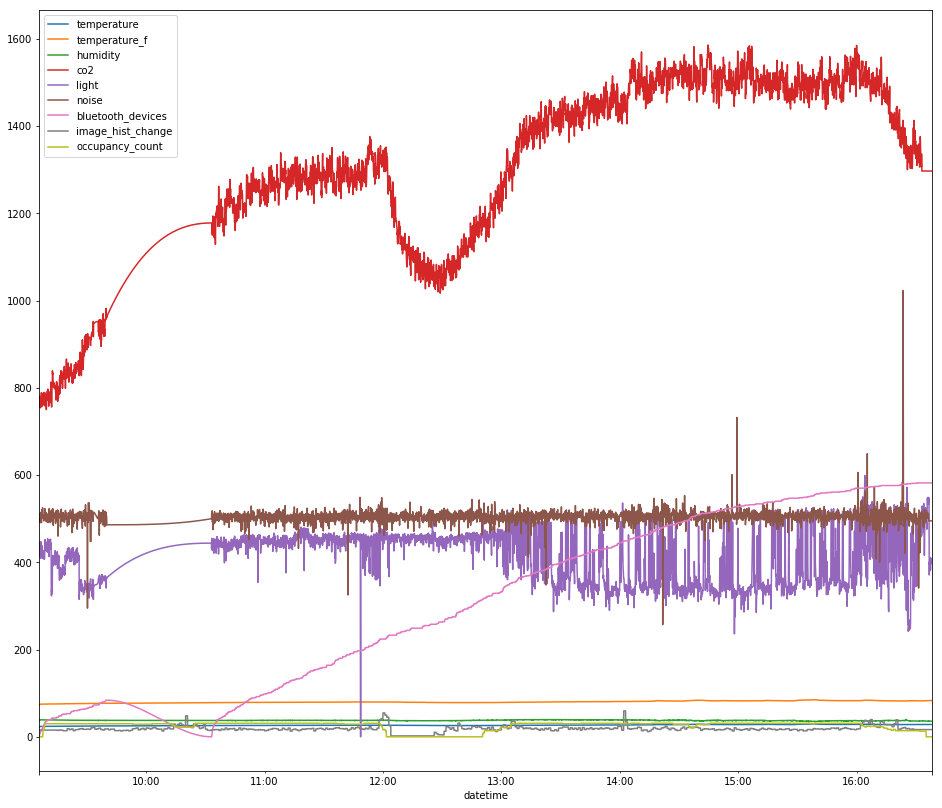

In [11]:
dataset_class['20170325'].plot(figsize=(16,14))

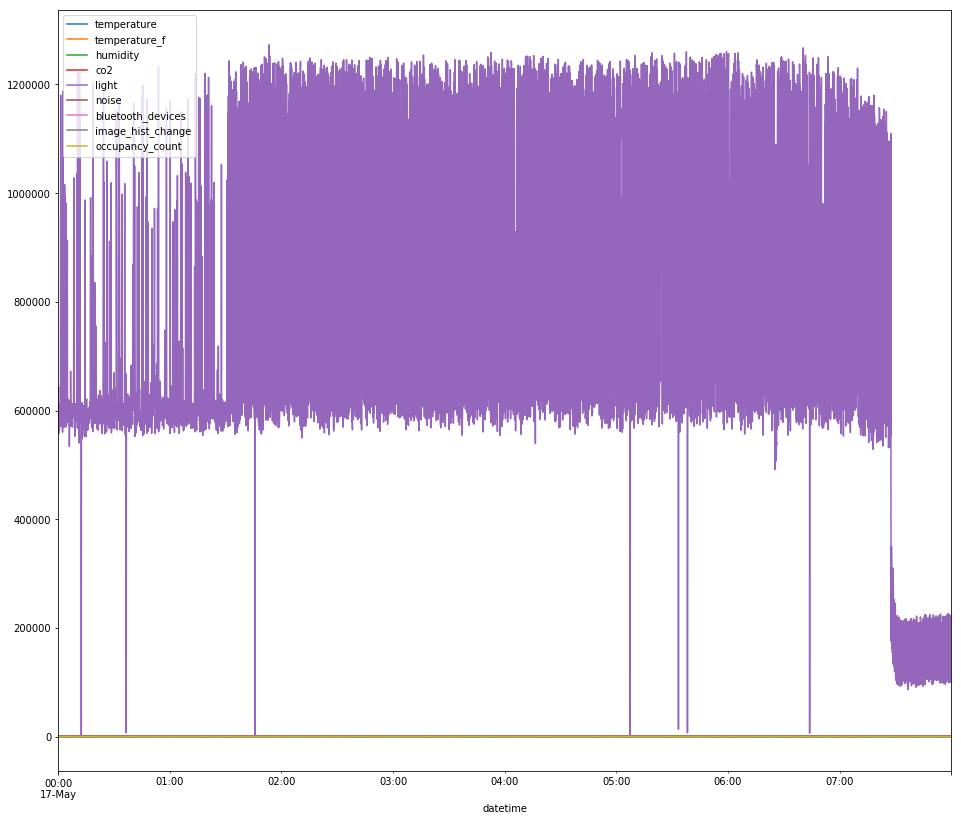

In [12]:
dataset_ofc['20170517'].plot(figsize=(16,14))

                     temperature  temperature_f  humidity         co2  \
datetime                                                                
2017-03-25 09:05:55         22.6          72.68      36.9  781.000000   
2017-03-25 09:06:00         23.8          74.84      39.0  767.000000   
2017-03-25 09:06:05         23.8          74.84      39.0  758.186441   

                         light light_status  noise  bluetooth_devices  \
datetime                                                                
2017-03-25 09:05:55  430.00000     light-on  511.0                1.0   
2017-03-25 09:06:00  448.00000     light-on  510.0                8.0   
2017-03-25 09:06:05  438.40493     light-on  510.5                8.0   

                     image_hist_change door_status  occupancy_count  \
datetime                                                              
2017-03-25 09:05:55          15.242697      closed              0.0   
2017-03-25 09:06:00          15.242697      closed     

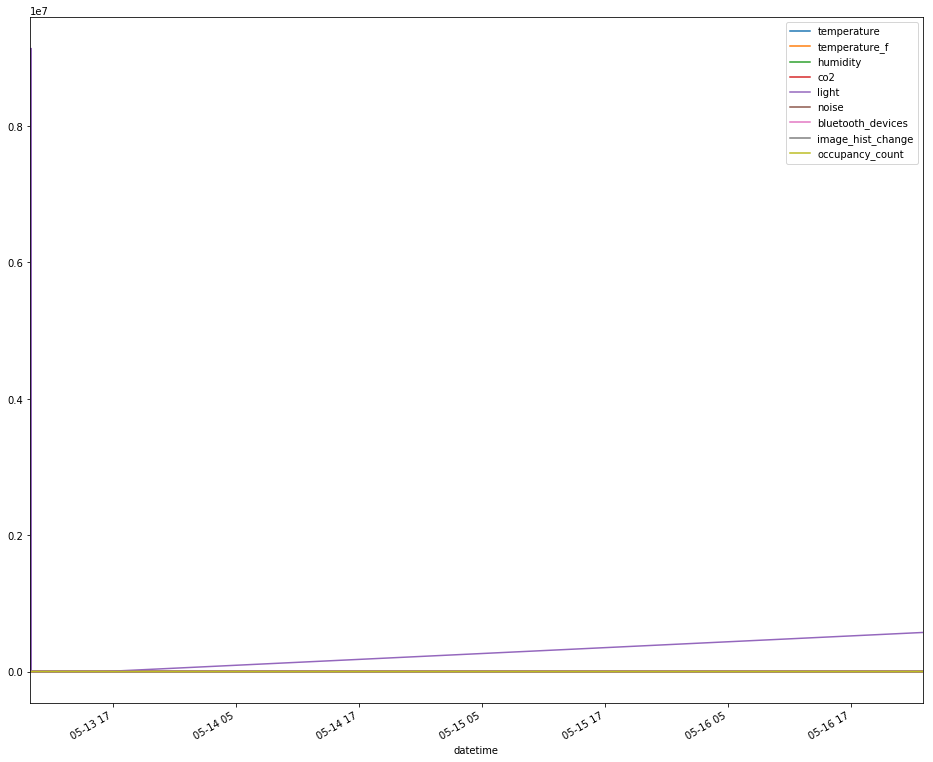

In [13]:
# appending and sorting datasets into final one
dataset = pd.concat([dataset_class,dataset_ofc])
dataset.sort_index(inplace=True)
print(dataset.head(3))
dataset[(dataset.index>='20170513') & (dataset.index<='20170517')].plot(figsize=(16,14))

In [14]:
# generating minute-by-minute versions
dataset_1M_class = COPP_Utils.interpolateByDay(dataset_class,'T',True)
dataset_1M_ofc = COPP_Utils.interpolateByDay(dataset,'T',True)

# appending and sorting datasets into final one
dataset_1M = pd.concat([dataset_1M_class,dataset_1M_ofc])
dataset_1M.sort_index(inplace=True)
dataset_1M.head(10)

,temperature,temperature_f,humidity,co2,light,light_status,noise,bluetooth_devices,image_hist_change,door_status,occupancy_count,occupancy_category
datetime,,,,,,,,,,,,
2017-03-25 09:05:00,22.60,72.68,36.9,781.0,430.000000,light-on,511.000000,1.0,15.242697,closed,0.0,very-low
2017-03-25 09:05:00,22.60,72.68,36.9,781.0,430.000000,light-on,511.000000,1.0,15.242697,closed,0.0,very-low
2017-03-25 09:06:00,23.80,74.84,38.9,789.0,437.000000,light-on,491.000000,16.0,15.242697,closed,0.0,very-low
2017-03-25 09:06:00,23.80,74.84,38.9,789.0,437.000000,light-on,491.000000,16.0,15.242697,closed,0.0,very-low
2017-03-25 09:07:00,23.85,74.93,38.8,766.0,421.653846,light-on,506.586957,25.0,15.242697,closed,15.0,low
2017-03-25 09:07:00,23.85,74.93,38.8,766.0,421.653846,light-on,506.586957,25.0,15.242697,closed,15.0,low
2017-03-25 09:08:00,23.90,75.02,38.8,784.0,431.000000,light-on,502.000000,34.0,15.242697,closed,30.0,high
2017-03-25 09:08:00,23.90,75.02,38.8,784.0,431.000000,light-on,502.000000,34.0,15.242697,closed,30.0,high
2017-03-25 09:09:00,24.00,75.20,38.8,792.0,441.000000,light-on,500.000000,37.0,15.242697,closed,30.0,high


In [15]:
# Export final datasets
dataset.to_csv('dataset-5sec.csv')
dataset_1M.to_csv('dataset-1min.csv')